In [3]:
!pip3 -qq install torch==1.4.0
!pip install -qq scikit-learn #==0.21.2
!pip install -qq numpy==1.16.4

!wget -O surnames.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ji7dhr9FojPeV51dDlKRERIqr3vdZfhu"

In [171]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

random.seed(1)

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor

    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    
    DEVICE = torch.device('cpu')
    
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Recurrent Neural Networks, Part 1

## Surname Classification

It's time to learn how to use RNNs - probably, the most widely-used type of neural networks in NLP applications. We are going to predict a language by a surname with its help.

In [172]:
data, labels = [], []
with open('surnames.txt') as f:
    for line in f:
        surname, lang = line.strip().split('\t')
        data.append(surname)
        labels.append(lang)

for i in np.random.randint(0, len(data), 10):
    print(data[i], labels[i])

Mikhnev Russian
Morcos Arabic
Morrow English
Berezinsky Russian
Badyaev Russian
Teale English
Prigorodov Russian
Greening English
Jankevich Russian
Bahin Russian


### Warming Up

Check yourself: try to predict what language the surnames are from :)

In [437]:
from sklearn.utils.class_weight import compute_class_weight

def test_generator():
    classes = np.unique(labels)
    weights = compute_class_weight('balanced', classes, labels)
    classes = {label: ind for ind, label in enumerate(classes)}

    probs = np.array([weights[classes[label]] for label in labels])
    probs /= probs.sum()

    ind = np.random.choice(np.arange(len(data)), p=probs)
    yield data[ind]
    
    while True:
        new_ind = np.random.choice(np.arange(len(data)), p=probs)
        yield labels[ind], data[new_ind]
        ind = new_ind
        
gen = test_generator()
question = next(gen)

/Users/sofiapetryshyn/opt/anaconda3/envs/ai_nlp/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=['Arabic' 'Chinese' 'Czech' 'Dutch' 'English' 'French' 'German' 'Greek'
 'Irish' 'Italian' 'Japanese' 'Korean' 'Polish' 'Portuguese' 'Russian'
 'Scottish' 'Spanish' 'Vietnamese'], y=['Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', 'Arabic', '

Run it:

In [438]:
#@title Check yourself (and the data) { run: "auto" }
answer = "Russian" #@param ["Arabic", "Chinese", "Czech", "Dutch", "English", "French", "German", "Greek", "Irish", "Italian", "Japanese", "Korean", "Polish", "Portuguese", "Russian", "Scottish", "Spanish", "Vietnamese"]

correct_answer, question = next(gen)
print("Example: ", correct_answer, question)

if 'correct_count' not in globals():
    correct_count = 0
    total_count = 0
else:
    if answer == correct_answer:
        print('You are correct', end=' ')
        correct_count += 1
    else:
        print("No, it's", correct_answer, end=' ')

    total_count += 1
    print('({} / {})'.format(correct_count, total_count))
    
print('Next surname:', question)

Example:  Arabic Noh
No, it's Arabic (0 / 14)
Next surname: Noh


### Data Preparation

First of all, we have to split the data on train and test.

We have to be careful: the classes are unballanced and we should split them proportionaly. The `stratify` parameter of the `train_test_split` will help us!

In [439]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42
)

In [440]:
data_train[:10]

['Nuallan',
 'Tseizik',
 'Bobienski',
 'Vavilov',
 'Böhmer',
 'Pavia',
 'Leibovsky',
 'Jakunkin',
 'Bonheur',
 'Vitrik']

In [441]:
labels_train[:10]

['Irish',
 'Russian',
 'Polish',
 'Russian',
 'German',
 'Spanish',
 'Russian',
 'Russian',
 'French',
 'Russian']

In [442]:
!pip install -qq matplotlib

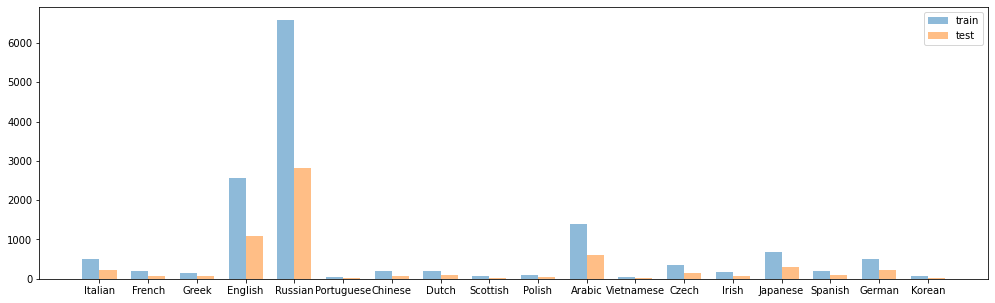

In [443]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

langs = set(labels)

train_distribution = Counter(labels_train)
train_distribution = [train_distribution[lang] for lang in langs]

test_distribution = Counter(labels_test)
test_distribution = [test_distribution[lang] for lang in langs]

plt.figure(figsize=(17, 5))

bar_width = 0.35
plt.bar(np.arange(len(langs)), train_distribution, bar_width, align='center', alpha=0.5, label='train')
plt.bar(np.arange(len(langs)) + bar_width, test_distribution, bar_width, align='center', alpha=0.5, label='test')
plt.xticks(np.arange(len(langs)) + bar_width / 2, langs)
plt.legend()
    
plt.show()

### Baseline

We are going to start with a baseline. **You should always start with a simple baseline.** 

**Task** That is, use logistic regression, Luke!

https://scikit-learn.org/stable/modules/compose.html#pipeline

In [444]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_train)

In [445]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


model = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1,4))),
    ('model', LogisticRegression())
])

model.fit(data_train, labels_train)

/Users/sofiapetryshyn/opt/anaconda3/envs/ai_nlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range=(1, 4))),
                ('model', LogisticRegression())])

What metrics are we going to calculate?

We are dealing with multi-class classification, so we have quite a wide range of options.

For instance, we can use accuracy or F1-score.

In [446]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

preds = model.predict(data_test)

print('Accuracy = {:.2%}'.format(accuracy_score(labels_test, preds)))
print('Classification report:')
print(classification_report(labels_test, preds))

assert accuracy_score(labels_test, preds) > 0.83, 'No, really, try smth better'

Accuracy = 83.18%
Classification report:
              precision    recall  f1-score   support

      Arabic       0.91      1.00      0.95       600
     Chinese       0.57      0.55      0.56        80
       Czech       0.56      0.33      0.41       156
       Dutch       0.85      0.49      0.62        89
     English       0.72      0.83      0.77      1101
      French       0.45      0.22      0.29        83
      German       0.60      0.52      0.56       217
       Greek       0.87      0.66      0.75        61
       Irish       0.55      0.44      0.49        70
     Italian       0.72      0.71      0.71       213
    Japanese       0.90      0.89      0.90       297
      Korean       0.33      0.29      0.31        28
      Polish       0.65      0.36      0.46        42
  Portuguese       0.19      0.14      0.16        22
     Russian       0.93      0.95      0.94      2823
    Scottish       0.00      0.00      0.00        30
     Spanish       0.46      0.28      0

It's not that simple with F1-score, actually. It's designed to be used in the binary classification setup. But we can adjust it to multi-class using:
- weighted averaging: the one that `classification_report` outputed. It tooks into account frequencies of classes and averages the scores by them.
- micro averaging: F1-score calculated by the aggregation of the all true positives, false positives and false negatives.
- macro averaging: mean of all F1-scores of the classes.

The first two are designed to deal with classes disballance, the last ignores it. Actully, it's up to you to decide, whether you need to predict classes equally good or the more frequent classes are more important to you.

We'll use weighted averaging, though.

<ipython-input-447-b580b55d0cdb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + label_names, rotation=45)
<ipython-input-447-b580b55d0cdb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + label_names)


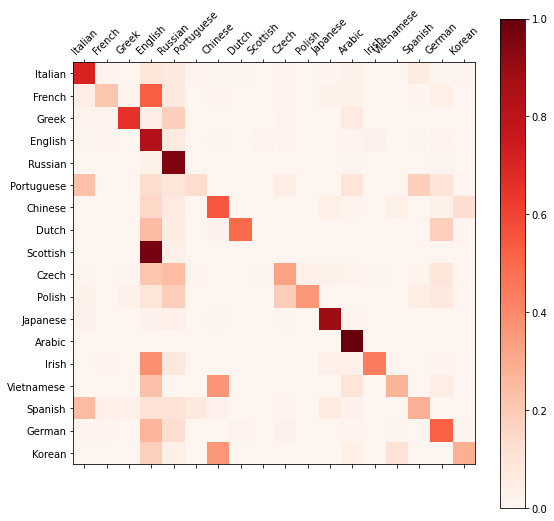

In [447]:
import matplotlib.ticker as ticker

label_names = list(set(labels_test))
confusion = confusion_matrix(labels_test, preds, labels=label_names).astype(np.float)
confusion /= confusion.sum(axis=-1, keepdims=True)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap='Reds')
fig.colorbar(cax)

ax.set_xticklabels([''] + label_names, rotation=45)
ax.set_yticklabels([''] + label_names)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## The Path of Neural Networks 

### Introduction to Recurrent Neural Networks

Let's say, we wanna apply a neural network now. What can we do based on the things we've already learned?

Compare the problem with the one we tackled in the previous notebook. We had a *sequence* of words there, and we have *sequence* of letters here. And we have to classify the sequences in both cases. It's quite similar, isn't it?

And, as you should have already guessed, the key ingredient in our disposal are embeddings. 

We can embed the letters as easily as we embedded words, you see.

Now, let's read the sequence the way you read it. Like, symbol-by-symbol:  
![](https://i.ibb.co/hM2pxJq/RNN-prediction.png)

The information we are reading can be stored in some special memory cell (a simple vector). For instance, the information that the word contains `ó` is meaningful enough to remember it during the whole reading process. Also `ski` is quite Polish suffix to simply forget about it. But we can see only one symbol at any moment, which means we should store also the information about possibility of the existance of the suffix `ski` in the word (its confidence is shown by different shades of green in the picture).

The final memory cell stores all interesting information about the word, so we can perform classification on top of it.

And well, that is. We almost invented recurrent neural networks! 

The idea behind RNNs is following: read given sequence sequentially and apply the same operation (that's why it's called *recurrent*) to every element of the sequence (and current memory cell) to obtain new memory cell. The arrows in the picture show the operation of rewriting the memory. All learnable parameters of the RNN are somewhere inside them.

![](https://i.ibb.co/0GPj9Zt/Rnn.png)

The picture above shows the learnable function as $f(x_t, h_{t-1})$, where $x_t$ is the embedding of the current element and $h_{t-1}$ is memory cell vector obtained from the previous step.

What function can be used?

The simplest choice is summation: we can sum all input embeddings. And we actually did something similar in our word2vec, remember?

Classical recurrent unit applies the following function:
$$f(x_t, h_{t-1}) = tanh(W_h [h_{t-1}; x_t] + b_h),$$
$$h_t = f(x_t, h_{t-1}),$$

where $[h_{t-1}; x_t]$ is simple concatenation of two vectors.

Let's implement it! And to test it, let's apply it to a simple problem: memorization of the first element in the sequence.
E.g., for the sequence `[1, 2, 1, 3]` correct output is `1`.

The batch generation function is following:

In [448]:
def generate_data(batch_size=128, seq_len=5):
    data = torch.randint(0, 10, size=(seq_len, batch_size), dtype=torch.long)
    return data, data[0]


X_val, y_val = generate_data()
# X_val, y_val

*NB.* Pay attention to the batch's dimensions: `(sequence_length, batch_size, input_size)`. All `RNN` cells in pytorch work with such format by default (but you can change the behaviour using the argument `batch_first`).

#### Our data:
batch_size=128, seq_len=5\
( 5, 128, input_size=1, as 1 column)

**Task** Implement the `SimpleRNN` class.

In [449]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, _hidden_size=None):
        """
        Args:
            input_size: dimention of input embedding
            hidden_size: hidden size
            dropout: dropout layer on the outputs of each RNN layer except the last layer
            bidirectional: if it is a bidirectional RNN
            num_layers: number of recurrent layers
            activation_function: the activation function of RNN, tanh/relu
        """
        super().__init__()
        self._hidden_size=hidden_size
        self.hiddens = []
        
        num_layers = 1
        activation_func = 'tanh'
        
        self.rnn = nn.RNN(input_size, hidden_size,
            num_layers=num_layers,
            nonlinearity=activation_func,
        )

    def forward(self, inputs, hidden=None):
        # inputs is a tensor in the time major format
        seq_len, batch_size = inputs.shape[:2]
        if hidden is None:
            # Initialize hidden with zeros
            hidden = inputs.new_zeros((1, batch_size, self._hidden_size))
        out, hidden = self.rnn(inputs, hidden)
        self.hiddens.append(hidden)

        return out, hidden[0]

In [450]:
sequence_length = 32
batch_size = 64
input_size = 10
hidden_size = 16

# SimpleRNN(10, 16)
rnn = SimpleRNN(input_size, hidden_size)

input_tensor = torch.randn((sequence_length, batch_size, input_size))

outputs = rnn(input_tensor)

assert isinstance(outputs, (list, tuple)), 'You should return both all hidden states tensor and the last hidden state'
assert len(outputs) == 2
assert outputs[0].shape == (sequence_length, batch_size, hidden_size)
assert outputs[1].shape == (batch_size, hidden_size)

In [451]:
# input_tensor[0]

Guess, it should more obvious why RNNs use so called time-major format by default: `inputs[i]` slice is contiguous in memory, while `inputs[:, i]` is not. It's much faster to perform matrix multiplications on contiguous memory chunks.  
A RNN cell with `batch_first=True` parameter is simply perform batch transposition twice: before and after RNN operations.

**Task** Implement `MemorizerModel` using a sequence of `Embedding -> SimpleRNN -> Linear` operations. (Remember, you can use `nn.Sequential` for such simple modules).

Let's use one-hot-encoding embeddings. That means we can use `torch.eye(N)` matrix to initialize embeddings (pass it to `nn.Embedding.from_pretrained` function).

In [452]:
class MemorizerModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.in_size = 10

        self._emb = nn.Embedding.from_pretrained(torch.eye(self.in_size))
        self._rnn = SimpleRNN(self.in_size, hidden_size)
        self._linear = nn.Linear(hidden_size, self.in_size)

    def forward(self, inputs):
        emb = self._emb(inputs)
        out, hidden = self._rnn(emb, None)
        
        return self._linear(hidden)

Simply run the training cycle:

In [456]:
rnn = MemorizerModel(hidden_size=16)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters())

total_loss = 0
epochs_count = 1000
max_seq_len = 10
for epoch_ind in range(epochs_count):
    X_train, y_train = generate_data(seq_len=np.random.randint(1, max_seq_len))
    
    optimizer.zero_grad()
    rnn.train()
    
    logits = rnn(X_train)

    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
    
    if (epoch_ind + 1) % 100 == 0:
        rnn.eval()
        
        with torch.no_grad():
            logits = rnn(X_val)
            val_loss = criterion(logits, y_val)
            print('[{}/{}] Train: {:.3f} Val: {:.3f}'.format(epoch_ind + 1, epochs_count, 
                                                             total_loss / 100, val_loss.item()))
            total_loss = 0

[100/1000] Train: 2.303 Val: 2.295
[200/1000] Train: 2.246 Val: 2.091
[300/1000] Train: 1.866 Val: 1.595
[400/1000] Train: 1.518 Val: 1.114
[500/1000] Train: 1.115 Val: 0.852
[600/1000] Train: 0.929 Val: 0.694
[700/1000] Train: 0.764 Val: 0.574
[800/1000] Train: 0.643 Val: 0.505
[900/1000] Train: 0.639 Val: 0.449
[1000/1000] Train: 0.458 Val: 0.318


And evalutation:

In [457]:
X_val, y_val = generate_data(seq_len=50)

logits = rnn(X_val)
loss = criterion(logits, y_val)

print('Accuracy = {}, Loss = {}'.format(((logits.argmax(-1) == y_val).float().sum() / y_val.shape[0]).item(), loss.item()))

Accuracy = 0.8125, Loss = 0.42369988560676575


You see, the network was trained to work with sequences with length up to 10 elements, but it's quite successful with a longer sequences to (well, it's not like the task was too hard, but still, impressive, isn't it?)

**Task** Try to vary the `max_seq_len` value. Check the model performance.

The expected behaviour is following: with `max_seq_len == 30` network already wouldn't be able to learn anything (and to work with a sequence with length equal to 50). It may seem to be counterintuitive: we are feeding the model with samples more similar to the target samples.

### RNNs' Training Notes

![bptt](https://image.ibb.co/cEYkw9/rnn_bptt_with_gradients.png)  
*From [Recurrent Neural Networks Tutorial, Part 3 – Backpropagation Through Time and Vanishing Gradients](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/)*

To understand the source of the obstacle you encountered in the previous section, you have to learn more about RNNs training. Check these posts: [Backpropagation Through Time and Vanishing Gradients](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/) and [Vanishing Gradients & LSTMs](http://harinisuresh.com/2016/10/09/lstms/).

There are two problems actually: *vanishing gradients* and *exploding gradients*. We just faced the first one: the output in our toy problem depended on the first element, so the gradient shouldn't vanish on the way back from last to first element. And when it didn't, the model'd successfully learned to memorize the first element (and the length of sequence it had been applied to mattered only a little). But when gradients vanished, model couldn't learn anything!

Another problem is *exploding gradients*. It has same source: repeated gradient multiplications on the backward pass. You should use gradients clipping more or less always to fight it. Just call `nn.utils.clip_grad_norm_(rnn.parameters(), 1.)` before optimizer's `step()`.

### Data Preprocessing

We are almost ready to solve the task using our `SimpleRNN`.

Let's collect some statistics from the dataset:

In [458]:
symbols = set(symb for word in data_train for symb in word)
char2ind = {symb: ind + 1 for ind, symb in enumerate(symbols)}
char2ind['<pad>'] = 0
ind2char = [symb for symb, _ in sorted(char2ind.items(), key=lambda pair: pair[1])]

lang2ind = {lang: ind for ind, lang in enumerate(set(labels_train))}

max_word_len = max(len(word) for word in data_train)

print('Chars index:', char2ind)
print('Langs index:', lang2ind)
print('Max word length:', max_word_len)

Chars index: {'ą': 1, 'ß': 2, 'õ': 3, 'b': 4, 'í': 5, 'a': 6, 'h': 7, 'p': 8, 'é': 9, 'ò': 10, 'B': 11, ':': 12, 'H': 13, 'ó': 14, 'É': 15, 't': 16, 'ì': 17, 'I': 18, 'r': 19, 'g': 20, 'z': 21, 'c': 22, 'Q': 23, 'G': 24, 'x': 25, 'o': 26, 'à': 27, 'S': 28, '1': 29, 'ö': 30, 'è': 31, 's': 32, 'e': 33, 'Y': 34, 'U': 35, 'k': 36, 'ł': 37, 'q': 38, ',': 39, 'á': 40, 'ã': 41, 'V': 42, "'": 43, 'L': 44, '\xa0': 45, 'f': 46, 'd': 47, 'i': 48, 'C': 49, 'u': 50, 'A': 51, 'T': 52, 'Z': 53, 'ü': 54, 'v': 55, 'ê': 56, 'm': 57, 'J': 58, 'Ż': 59, 'ä': 60, 'ñ': 61, 'X': 62, 'y': 63, '/': 64, 'ú': 65, 'j': 66, 'Ś': 67, 'Á': 68, 'P': 69, 'D': 70, 'w': 71, 'F': 72, 'M': 73, 'N': 74, 'W': 75, '-': 76, 'ń': 77, 'E': 78, 'ç': 79, ' ': 80, 'n': 81, 'R': 82, 'K': 83, 'l': 84, 'O': 85, '<pad>': 0}
Langs index: {'Italian': 0, 'French': 1, 'Greek': 2, 'English': 3, 'Russian': 4, 'Portuguese': 5, 'Scottish': 6, 'Dutch': 7, 'Chinese': 8, 'Polish': 9, 'Arabic': 10, 'Japanese': 11, 'Czech': 12, 'Irish': 13, 'Vietna

... and convert the dataset to a format understandable by a neural network.

**Task** Convert the data and implement the batches genetator.

In [459]:
# char2ind
data[0], labels[0]

('Khoury', 'Arabic')

In [460]:
def convert_data(data, labels, char2ind, label2ind):
#     <convert the data and labels to numpy matrices>
    res_x = []
    res_y = np.zeros(len(data), dtype=int)
    for i, name in enumerate(data):
        res_x.append([])
        for j, letter in enumerate(name):
            try:
                res_x[-1].append(char2ind[letter])
            except KeyError:
                pass
        for _ in range(20 - len(res_x[-1])):
            res_x[-1].append(0)
        res_y[i] = lang2ind[labels[i]]
    return res_x, res_y


X_train, y_train = convert_data(data_train, labels_train, char2ind, lang2ind)
X_test, y_test = convert_data(data_test, labels_test, char2ind, lang2ind)

In [461]:
assert len(X_train) == len(y_train) == len(data_train)
assert len(X_test) == len(y_test) == len(data_test)
assert len(y_train.shape) == 1, 'Labels should be stored in a numpy array'
assert isinstance(X_train[0], list) and isinstance(X_train[0][0], int), 'Store lists of indices in the data array'

**Task** Finish the batch iterator function implementation:

In [462]:
def non_zeroes(arr):
    return len([x for x in arr if x != 0])

def iterate_batches(data, batch_size):
    X, y = data
    num_samples = len(X)

    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        
        batch_indices = indices[start:end]
        X_batch = [X[b_i] for b_i in batch_indices]
        lengths = np.array([non_zeroes(b_i) for b_i in X_batch]).T
        y_batch = np.array([y[b_i] for b_i in batch_indices]).T
        X_batch = np.array(X_batch).T
        yield {
            'tokens': LongTensor(X_batch),
            'lengths': LongTensor(lengths),
            'labels': LongTensor(y_batch)
        }

In [463]:
batch = next(iterate_batches((X_train, y_train), batch_size=8))

assert isinstance(batch, dict)
assert isinstance(batch['tokens'], LongTensor) and batch['tokens'].shape[1] == 8
assert isinstance(batch['lengths'], LongTensor) and batch['lengths'].shape == (8,)
assert isinstance(batch['labels'], LongTensor) and batch['labels'].shape == (8,)

### Model Implementation

**Task** Implement a simple model based on `SimpleRNN`.

In [464]:
class SurnamesClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, rnn_hidden_dim, classes_count):
        super().__init__()
        self._vocab_size = vocab_size
        self._emb_dim = emb_dim
        self._rnn_hidden_dim = rnn_hidden_dim
        self._classes_count = classes_count
        
        self._emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self._rnn = SimpleRNN(emb_dim, rnn_hidden_dim)
        self._linear = nn.Linear(rnn_hidden_dim, classes_count)
            
    def forward(self, tokens, lengths, **kwargs):
        """
        Applies embed(tokens, lengths) to obtain word embeddings 
         and applies output nn.Linear layer to classify them
        """
        out, hidden = self.embed(tokens, lengths)
        
        return self._linear(hidden)
    
    def embed(self, tokens, lengths):
        """
        Builds character-level word embeddings for the given tokens
        (use the last rnn's state)
        """
        return self._rnn(self._emb(tokens))

In [465]:
import math
import time


def do_epoch(model, criterion, data, batch_size, optimizer=None):  
    epoch_loss = 0.
    
    is_train = not optimizer is None
    model.train(is_train)
    
    data, labels = data
    batchs_count = math.ceil(len(data) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        for i, batch in enumerate(iterate_batches((data, labels), batch_size)):
            logits = model(**batch)
            loss = criterion(logits, batch['labels'])
            epoch_loss += loss.item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.)
                optimizer.step()

            print('\r[{} / {}]: Loss = {:.4f}'.format(i, batchs_count, loss.item()), end='')
                
    return epoch_loss / batchs_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, 
        batch_size=32, val_data=None, val_batch_size=None):
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        start_time = time.time()
        train_loss = do_epoch(model, criterion, train_data, batch_size, optimizer)
        
        output_info = '\rEpoch {} / {}, Epoch Time = {:.2f}s: Train Loss = {:.4f}'
        if not val_data is None:
            val_loss = do_epoch(model, criterion, val_data, val_batch_size, None)
            
            epoch_time = time.time() - start_time
            output_info += ', Val Loss = {:.4f}'
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss, val_loss))
        else:
            epoch_time = time.time() - start_time
            print(output_info.format(epoch+1, epochs_count, epoch_time, train_loss))

In [466]:
len(lang2ind), len(char2ind)

(18, 86)

In [467]:
model = SurnamesClassifier(vocab_size=len(char2ind), emb_dim=32, rnn_hidden_dim=128, classes_count=len(lang2ind))
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, epochs_count=10, batch_size=32, train_data=(X_train, y_train),
    val_data=(X_test, y_test), val_batch_size=512)

RuntimeError: size mismatch, m1: [32 x 16], m2: [128 x 18] at ../aten/src/TH/generic/THTensorMath.cpp:136

### Evaluation

**Task** Check the model, try to predict the language for your own surname:

In [ ]:
# Do NOT forget to turn on eval mode
model.eval()

# You don't need to do backprop, so...
with torch.no_grad():
    <your code>

**Task** Evaluate the model:

In [ ]:
def evaluate_model(model, X_test, y_test):
    <collect y_true & y_pred>
    
    assert y_test.shape[0] == len(y_true) == len(y_pred)
        
    print('Accuracy = {:.2%}'.format(accuracy_score(y_true, y_pred)))
    print('Classification report:')
    print(classification_report(
        y_true, y_pred, target_names=[lang for lang, _ in sorted(lang2ind.items(), key=lambda x: x[1])]
    ))
    
    return accuracy_score(y_true, y_pred)

In [ ]:
assert evaluate_model(model, X_test, y_test) > 0.77

## The Curious Case of the Lost Percents

### On RNNs Output States

'What the heck, why the quality is so low?', you're asking me. Well, the main thing is: we are not using the RNN output states properly. Still. It's time to fix it.

You see, the output states of a RNN (the first output our `SimpleRNN`) look this way:  
![](https://i.ibb.co/rw6CQw0/RNN-outputs.png)

It's a 3D tensor `(sequence_length, batch_size, hidden_size)`.

We are using the last slice of the tensor to classify the sequence. But wait, the sequences in our batch have different lengths! Most of them are shorter and filled with paddings in the end (the white cells in the picture).

So, basically, we are using wrong states to classify the sequence. Of course, they should have contained the information about the sequence, but... The network might easily forget everything as we just saw in our toy `MemorizerModel` example.

Let's deal with it. Let's slice the tensor to obtain the last state of the sequences.

We'll start with a simpler tensor to test it.

In [ ]:
sequence_length = 5
batch_size = 4

data = torch.arange(20).view(sequence_length, batch_size)
lengths = torch.tensor([3, 2, 5, 4])

data, lengths

**Task** Use a single slice operation to get the `last_states`.

In [ ]:
last_states = data[lengths - 1, torch.arange(4)]

assert torch.all(last_states == torch.tensor([8, 5, 18, 15]))

**Task** Use the same operation to get correct last states in the `embed` method. Train network and compare its performance with the old result. 

In [ ]:
<train the model>

In [ ]:
assert evaluate_model(model, X_test, y_test) > 0.80

### LSTM & GRU

Guess, it's time to try something more substantial to beat logistic regression. We've already learned that RNNs' weak point is their forgetfulness. And vanishing gradients are at the core of it.

There is a way to deal with it - so called *gates*. The idea behind a *gate* is simple: we should give our network a mechanism to control its own memory.

You see, our `SimpleRNN` overrides its own memory vector $h_{t-1}$ every time it meets a new input $x_t$. In a way, it's like an amnesiac fish:  
![](https://i.ibb.co/WVJXT2t/bhwrog1.jpg)

Let's generate a vector $g \in \{0,1\}^n$ that will define which elements in $h_{t-1}$ are useful and which should be updated by the new came information:
$$h_t = g \odot f(x_t, h_{t-1}) + (1 - g) \odot h_{t-1},$$ where $ \odot$ is elementwise multiplication.

For instance,
$$
 \begin{bmatrix}
  8 \\
  11 \\
  3 \\
  7
 \end{bmatrix} =
 \begin{bmatrix}
  0 \\
  1 \\
  0 \\
  0
 \end{bmatrix}
 \odot
  \begin{bmatrix}
  7 \\
  11 \\
  6 \\
  5
 \end{bmatrix}
 +
  \begin{bmatrix}
  1 \\
  0 \\
  1 \\
  1
 \end{bmatrix}
 \odot
  \begin{bmatrix}
  8 \\
  5 \\
  3 \\
  7
 \end{bmatrix}
$$

And we need a differentiable function, so instead of $g \in {0, 1}$ we'll use $\sigma(q(x_t, h_{t-1})) \in [0, 1]$.

As a result, the network should learn itself to choose what to remember.

The first architecture successfully applied this idea was LSTM (Long Short-Term Memory).

Well, the first difference is that memory state consists of two vectors: $[h_t, c_t]$.

The computations look a bit more complicated that I sketched them above.

The first step looks similar to vanilla RNN computations:
$$\tilde c_{t} = tanh(W_h [h_{t-1}; x_t] + b_h)$$

Remember, in our implementation we used the vector as the next memory state. But now we are going to mix the $\tilde c_t$ with old memory state $c_{t-1}$.  How? That's exactly where the gates come to play!

We'll predict two values:
$$f = \sigma(W_f [h_{t-1}; x_t] + b_f),$$
$$i = \sigma(W_i [h_{t-1}; x_t] + b_i).$$

The first one we are going to use as a *forget* gate (which parts we wanna forget). The second is *input* gate (which parts of the new state are the most useful):
$$c_t = f \odot c_{t-1} + i \odot \tilde c_t.$$

We got our new memory state! Now let's decide, what to output:
$$o = \sigma(W_o [h_{t-1}; x_t] + b_o),$$
$$h_t = o \odot tanh(c_t).$$

$h_t$ is (again) the outputed state of the cell. Cell is looking at the memory state and deciding what should be shown to the world

The whole process in one picture:

![](https://image.ibb.co/e6HQUU/details.png)  
*From [Vanishing Gradients & LSTMs](http://harinisuresh.com/2016/10/09/lstms/)*

Why does the thing help anyhow? Look at the gradient $\frac{\partial c_t}{\partial c_{t-1}}$. It is proportional to the forget gate $f$. When $f$ is equal to one, gradients are unchanged. So it's possible to learn not to forget anything (as well as forget useless things).

To gain a better insight check this wonderful post: [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

**Task** The theory may seem to be confusing, but there is nothing simpler than try it in practice. Just replace `SimpleRNN` with `nn.LSTM` module. Do it!

In [ ]:
<train a model with LSTM RNN>

In [ ]:
assert evaluate_model(model, X_test, y_test) > 0.82

## The Final Quest

Let's beat our logistic regression baseline!

**Task** A common RNNs' extension is *Bidirectional* RNN. Basically, it's two RNNs, one (forward) reads sequence left to right, another (backward) - right to left.

The result hidden state is $h_t = [f_t; b_t]$. You see, the $f_t$ is context representation of the first $t$ elements, the $b_t$ is context embedding of the last $T-t$ elements. Which means that $h_t$ contains information about the whole sequence.

Use `LSTM`'s' parameter `bidirectional=True` to turn the mode on.

In this case you should probably use [`PackedSequence`](https://pytorch.org/docs/stable/nn.html#packedsequence) to obtain a correct `last_state`. It's just a handy alternative to the way we implemented our `last_state` extraction (Oh, did you really think it's not in the library already?).

Simply call `pack_padded_sequence` to create `PackedSequence` and call `pad_packed_sequence` to obtain an ordinary tensor back:

```python
embs = nn.utils.rnn.pack_padded_sequence(embs, lengths, enforce_sorted=False)
states, (last_state, _) = self._rnn(embs)
states, _ = nn.utils.rnn.pad_packed_sequence(states)
```

**Task** Add `nn.Dropout` whereever it helps. It really do help!